## Mounting Drive, Downloading dataset & extracting zip file 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/5554

/content/drive/MyDrive/5554


In [ ]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2022-11-28 02:05:24--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2022-11-28 02:05:25--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.29.56, 52.218.96.155, 52.218.25.200, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.29.56|:4

In [2]:
cd /content

/content


In [3]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Importing Libraries

In [5]:
import numpy as np
import pickle
import cv2
import os
import tensorflow
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import shutil as sh
import pandas as pd
from tqdm import tqdm
from os import listdir
import tensorflow as tf
from pathlib import Path
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

## Getting image count per folder

In [6]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
count = 1
total = 0
for folder in folders:
  print("{}.{} : {}".format(count, folder, len(os.listdir(dataset_path + folder))))
  count+=1
  total+= len(os.listdir(dataset_path + folder))
print("Total Images : {}".format(total))

1.Tomato___Target_Spot : 1404
2.Background_without_leaves : 1143
3.Tomato___Leaf_Mold : 1000
4.Apple___Apple_scab : 1000
5.Grape___Esca_(Black_Measles) : 1383
6.Potato___Early_blight : 1000
7.Blueberry___healthy : 1502
8.Orange___Haunglongbing_(Citrus_greening) : 5507
9.Strawberry___Leaf_scorch : 1109
10.Soybean___healthy : 5090
11.Tomato___Spider_mites Two-spotted_spider_mite : 1676
12.Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 1076
13.Peach___healthy : 1000
14.Tomato___Early_blight : 1000
15.Corn___Common_rust : 1192
16.Tomato___Tomato_mosaic_virus : 1000
17.Pepper,_bell___healthy : 1478
18.Peach___Bacterial_spot : 2297
19.Corn___healthy : 1162
20.Tomato___Tomato_Yellow_Leaf_Curl_Virus : 5357
21.Potato___Late_blight : 1000
22.Cherry___Powdery_mildew : 1052
23.Apple___Black_rot : 1000
24.Raspberry___healthy : 1000
25.Strawberry___healthy : 1000
26.Apple___Cedar_apple_rust : 1000
27.Corn___Cercospora_leaf_spot Gray_leaf_spot : 1000
28.Tomato___Bacterial_spot : 2127
29.Cherry___health

## Getting names of all subfolders and storing them in variables for indexing and referencing purposes

In [7]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
folders

dataset_index = {}

for folder in folders:
  leaf_type = folder.split("_")[0].replace(",", "")
  if leaf_type in dataset_index.keys():
    dataset_index[leaf_type].append(folder)
  else:
    dataset_index[leaf_type] = [folder]

dataset_index

{'Tomato': ['Tomato___Target_Spot',
  'Tomato___Leaf_Mold',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Early_blight',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Bacterial_spot',
  'Tomato___healthy',
  'Tomato___Late_blight',
  'Tomato___Septoria_leaf_spot'],
 'Background': ['Background_without_leaves'],
 'Apple': ['Apple___Apple_scab',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  'Apple___healthy'],
 'Grape': ['Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Grape___Black_rot'],
 'Potato': ['Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy'],
 'Blueberry': ['Blueberry___healthy'],
 'Orange': ['Orange___Haunglongbing_(Citrus_greening)'],
 'Strawberry': ['Strawberry___Leaf_scorch', 'Strawberry___healthy'],
 'Soybean': ['Soybean___healthy'],
 'Peach': ['Peach___healthy', 'Peach___Bacterial_spot'],
 'Corn': ['Corn___Common_rust',
  'Corn_

In [8]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)
folders
# dictionary to categorize variations of different types of leaves we have
type_of_leaves = {}

for folder in folders:
  leaf_type = folder.split("_")[0].replace(",", "")
  #print("Leaf Type: {}".format(leaf_type))
  variation = " ".join(folder.split("_")[1:]).strip()
  #print("Variation: {}".format(variation))
  if leaf_type in type_of_leaves.keys():
    type_of_leaves[leaf_type].append(variation)
  else:
    type_of_leaves[leaf_type] = [variation]

type_of_leaves

{'Tomato': ['Target Spot',
  'Leaf Mold',
  'Spider mites Two-spotted spider mite',
  'Early blight',
  'Tomato mosaic virus',
  'Tomato Yellow Leaf Curl Virus',
  'Bacterial spot',
  'healthy',
  'Late blight',
  'Septoria leaf spot'],
 'Background': ['without leaves'],
 'Apple': ['Apple scab', 'Black rot', 'Cedar apple rust', 'healthy'],
 'Grape': ['Esca (Black Measles)',
  'Leaf blight (Isariopsis Leaf Spot)',
  'healthy',
  'Black rot'],
 'Potato': ['Early blight', 'Late blight', 'healthy'],
 'Blueberry': ['healthy'],
 'Orange': ['Haunglongbing (Citrus greening)'],
 'Strawberry': ['Leaf scorch', 'healthy'],
 'Soybean': ['healthy'],
 'Peach': ['healthy', 'Bacterial spot'],
 'Corn': ['Common rust',
  'healthy',
  'Cercospora leaf spot Gray leaf spot',
  'Northern Leaf Blight'],
 'Pepper': ['bell   healthy', 'bell   Bacterial spot'],
 'Cherry': ['Powdery mildew', 'healthy'],
 'Raspberry': ['healthy'],
 'Squash': ['Powdery mildew']}

In [9]:
# eligible types of classification based on data
eligible_types = ['Pepper', 'Tomato', 'Corn', 'Grape', 'Apple', 'Strawberry', 'Peach', 'Cherry', 'Potato']

In [10]:
eligible_types_stats = {}

for eligible_type in eligible_types:

  subset_of_folders = []
  for folder in folders:
    if eligible_type in folder:
      subset_of_folders.append(folder)

  # getting subsets properly, checked manually for each eligible type
  #subset_of_folders

  count_healthy_leaves = 0
  count_diseased_leaves = 0

  for subset_folder in subset_of_folders:
    if "healthy" in subset_folder:
      count_healthy_leaves = len(os.listdir(dataset_path + subset_folder + "/"))
    else:
      count_diseased_leaves+= len(os.listdir(dataset_path + subset_folder + "/"))

  eligible_types_stats[eligible_type] = "healthy: {} | diseased: {}".format(count_healthy_leaves, count_diseased_leaves)

eligible_types_stats

{'Pepper': 'healthy: 1478 | diseased: 1000',
 'Tomato': 'healthy: 1591 | diseased: 17244',
 'Corn': 'healthy: 1162 | diseased: 3192',
 'Grape': 'healthy: 1000 | diseased: 3639',
 'Apple': 'healthy: 1645 | diseased: 3000',
 'Strawberry': 'healthy: 1000 | diseased: 1109',
 'Peach': 'healthy: 1000 | diseased: 2297',
 'Cherry': 'healthy: 1000 | diseased: 1052',
 'Potato': 'healthy: 1000 | diseased: 2000'}

## Displays random images of all categories for a specific leaf type

In [11]:
# Displays random images of all categories for a specific leaf type
def show_all_categories_of_type(eligible_type):
  plt.figure(figsize=(50,50))
  number_of_categories = len(dataset_index[eligible_type])

  def read_img_and_show(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  for i in range(number_of_categories):
    category = dataset_index[eligible_type][i]
    path_to_folder = dataset_path + category + "/"
    random_image_number = random.randint(1, len(os.listdir(path_to_folder)))
    image_name = "image ({}).JPG".format(random_image_number)
    plt.subplot(1, number_of_categories, i+1)
    #plt.gca().set_title(" ".join(category.split("_")[1:]) + " : {}".format(image_name))
    plt.title(" ".join(category.split("_")[1:]) + " : {}".format(image_name), fontsize=25)
    plt.axis('off')
    plt.imshow(read_img_and_show(path_to_folder + image_name))
  
  plt.show()

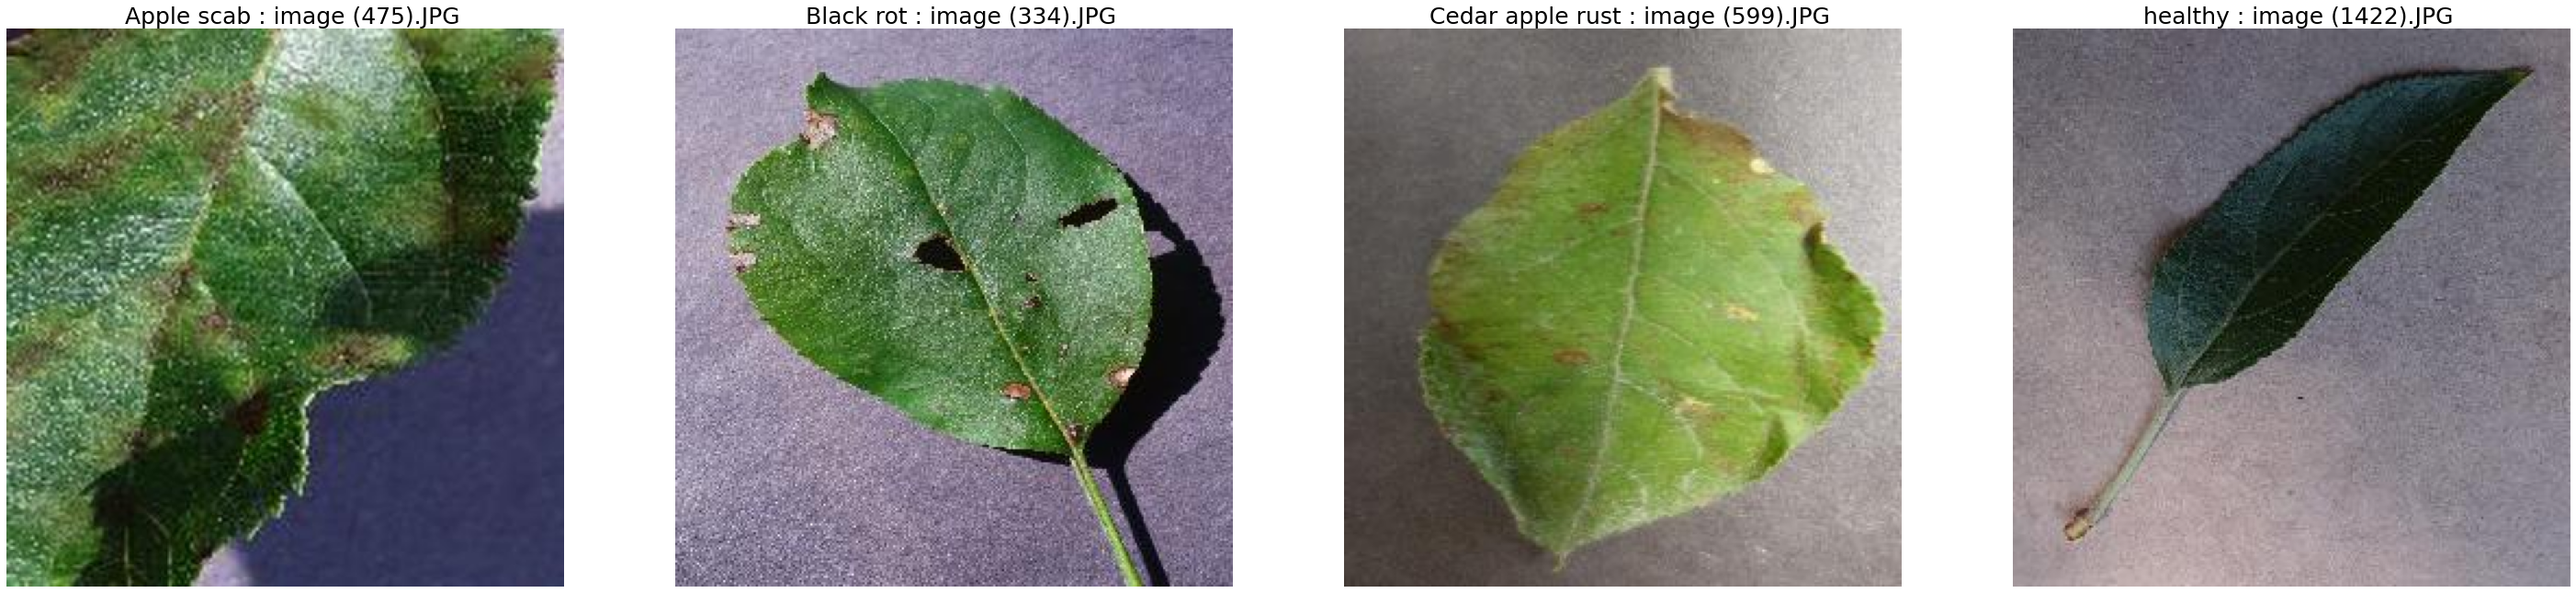

In [12]:
show_all_categories_of_type("Apple")

## Creating curated dataset for binary classification for a specific leaf type

In [44]:
# creating folder structure for specific eligible type of leaf
eligible_type = "Apple"

base_path = "/content/"
curated_dataset = "curated_dataset/" 
classes = ["healthy", "diseased"]

for c in classes:
  path = base_path + curated_dataset + eligible_type + "/" + c + "/"
  p = pathlib.Path(path)
  p.mkdir(parents=True, exist_ok=True)

In [45]:
# copying images from source subfolders to destination class folders ("healthy" & "diseased") for a specific eligible type of leaf

eligible_type = "Apple"

# source variables
source_dataset = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
source_folders = dataset_index[eligible_type]

# destination variables
destination_dataset = "/content/curated_dataset/{}/".format(eligible_type)
classes = ["healthy", "diseased"]
healthy_count = 0
diseased_count = 0

for source_folder in tqdm(source_folders):
  source_path = source_dataset +  source_folder + "/"
  source_image_list = os.listdir(source_path)
  for i in range(len(source_image_list)):
    source_image = source_image_list[i]
    source = source_path + source_image
    if "healthy" in source_folder:
      healthy_count+=1
      destination = destination_dataset + classes[0] + "/" + source_folder+"__"+source_image
    else:
      diseased_count+=1
      destination = destination_dataset + classes[1] + "/" + source_folder+"__"+source_image
    sh.copyfile(source, destination)

#print("For leaf type : {}".format(eligible_type))
#print("No. of healthy leaves : {}".format(healthy_count))
#print("No. of diseased leaves : {}".format(diseased_count))

100%|██████████| 4/4 [00:00<00:00, 10.24it/s]


In [46]:
# verifying copied images in terms of counts in the destination folders

# check if this count matches with the count for leaf type in stats output

print("For leaf type : {}".format(eligible_type))
print("No. of healthy leaves : {}".format(len(os.listdir(destination_dataset + classes[0]+"/"))))
print("No. of diseased leaves : {}".format(len(os.listdir(destination_dataset + classes[1]+"/"))))

For leaf type : Apple
No. of healthy leaves : 1645
No. of diseased leaves : 3000


## Dataset for ImageDataGenerator

In [47]:
root_dir = '/content/curated_dataset/'
eligible_type = 'Apple'
root_dir = root_dir + eligible_type + "/"

In [48]:
#generating dataframes of images and labels
image_list = []
label_list = []

folders = os.listdir(root_dir)

try:
  for folder in tqdm(folders):
    img_paths = os.listdir(root_dir + folder + "/")
    for img_path in img_paths:
      source = root_dir+folder+"/"+img_path
      if source.endswith(".jpg")==True or source.endswith(".JPG")==True:
          image_list.append(source)
          label_list.append(folder)
except Exception as e:
    print(f"Error : {e}")
data = pd.DataFrame()
data['FileName']= image_list
data['Label']= label_list
data.shape

100%|██████████| 2/2 [00:00<00:00, 226.85it/s]


(4645, 2)

In [49]:
data

FileName     Label
0     /content/curated_dataset/Apple/diseased/Apple_...  diseased
1     /content/curated_dataset/Apple/diseased/Apple_...  diseased
2     /content/curated_dataset/Apple/diseased/Apple_...  diseased
3     /content/curated_dataset/Apple/diseased/Apple_...  diseased
4     /content/curated_dataset/Apple/diseased/Apple_...  diseased
...                                                 ...       ...
4640  /content/curated_dataset/Apple/healthy/Apple__...   healthy
4641  /content/curated_dataset/Apple/healthy/Apple__...   healthy
4642  /content/curated_dataset/Apple/healthy/Apple__...   healthy
4643  /content/curated_dataset/Apple/healthy/Apple__...   healthy
4644  /content/curated_dataset/Apple/healthy/Apple__...   healthy

[4645 rows x 2 columns]

In [50]:
# 70 - 20 - 10 split

In [51]:
train, test= train_test_split(data, test_size=0.1, shuffle= True, random_state = 100, stratify=data['Label'])

In [52]:
train, val = train_test_split(train, test_size=0.2222, shuffle=True, random_state =100, stratify=train['Label'])

In [53]:
train.shape

(3251, 2)

In [54]:
val.shape

(929, 2)

In [55]:
test.shape

(465, 2)

In [56]:
eligible_type = "Apple"
base_path = "/content/final_dataset/" + eligible_type + "/"
folders = ["train", "val", "test"] 
classes = ["healthy", "diseased"]

for f in folders:
  for c in classes:
    path = base_path + f + "/" + c
    p = pathlib.Path(path)
    p.mkdir(parents=True, exist_ok=True)

In [57]:
eligible_type = "Apple"
base_path = "/content/final_dataset/" + eligible_type + "/"

for index, row in tqdm(train.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "train" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

3251it [00:01, 1777.83it/s]


In [59]:
eligible_type = "Apple"
base_path = "/content/final_dataset/" + eligible_type + "/"

for index, row in tqdm(val.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "val" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

929it [00:00, 5202.35it/s]


In [60]:
eligible_type = "Apple"
base_path = "/content/final_dataset/" + eligible_type + "/"

for index, row in tqdm(test.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "test" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

465it [00:00, 5146.22it/s]


## Model

In [70]:
def cnn(input_shape = (256, 256, 3), lr = 1e-3, factor = 4):
    img_input = layers.Input(input_shape)
    X = layers.Conv2D(factor, 3, padding = 'same', activation = 'relu')(img_input)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*2, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*4, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*8, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*16, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.Dropout(rate=0.5)(X)
    X = layers.Dense(1)(X)
    X = layers.Activation('sigmoid', dtype='float32', name='predictions')(X)
    model = models.Model(inputs = img_input, outputs = X)
    model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

## Load Dataset

In [71]:
batch_size = 64
target_size = (256, 256)
color_mode = "rgb"
eligible_type = "Apple"
dataset = '/content/final_dataset' + "/" + eligible_type
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(f'{dataset}/train/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)
val_generator = val_datagen.flow_from_directory(f'{dataset}/val/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)
test_generator = test_datagen.flow_from_directory(f'{dataset}/test/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)

Found 3251 images belonging to 2 classes.
Found 929 images belonging to 2 classes.
Found 465 images belonging to 2 classes.


## Training

In [74]:
model_path = 'models/'
Path(model_path).mkdir(parents=True, exist_ok = True)
checkpointer = ModelCheckpoint(model_path+f'/cnn_'+'epochs:{epoch:02d}_acc:{val_accuracy:.4f}.h5', monitor = 'val_loss', save_best_only = True, verbose = 0, mode = 'auto')
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0, mode = 'auto')
reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 1/np.sqrt(10), patience = 3, cooldown = 1, verbose = 0, mode = 'auto')
model = cnn((256,256,3))
history = model.fit(train_generator, steps_per_epoch = len(train_generator), verbose = 2, epochs = 30, callbacks = [checkpointer, earlystopper, reduceLR], validation_data=val_generator, validation_steps = len(val_generator))

Epoch 1/30
51/51 - 12s - loss: 0.4307 - accuracy: 0.7979 - val_loss: 0.3080 - val_accuracy: 0.8848 - lr: 0.0010 - 12s/epoch - 243ms/step
Epoch 2/30
51/51 - 12s - loss: 0.2860 - accuracy: 0.8930 - val_loss: 0.2583 - val_accuracy: 0.9225 - lr: 0.0010 - 12s/epoch - 230ms/step
Epoch 3/30
51/51 - 10s - loss: 0.2498 - accuracy: 0.9120 - val_loss: 0.2033 - val_accuracy: 0.9311 - lr: 0.0010 - 10s/epoch - 198ms/step
Epoch 4/30
51/51 - 10s - loss: 0.2007 - accuracy: 0.9323 - val_loss: 0.1782 - val_accuracy: 0.9365 - lr: 0.0010 - 10s/epoch - 193ms/step
Epoch 5/30
51/51 - 10s - loss: 0.1812 - accuracy: 0.9317 - val_loss: 0.1601 - val_accuracy: 0.9440 - lr: 0.0010 - 10s/epoch - 196ms/step
Epoch 6/30
51/51 - 10s - loss: 0.1618 - accuracy: 0.9409 - val_loss: 0.1356 - val_accuracy: 0.9559 - lr: 0.0010 - 10s/epoch - 192ms/step
Epoch 7/30
51/51 - 12s - loss: 0.1484 - accuracy: 0.9477 - val_loss: 0.1303 - val_accuracy: 0.9569 - lr: 0.0010 - 12s/epoch - 230ms/step
Epoch 8/30
51/51 - 10s - loss: 0.1253 - a

## Saving model weights

In [75]:
source = "/content/models"
destination = "/content/drive/MyDrive/5554/binary_specific_leaf_type/models"
sh.copytree(source, destination)

'/content/drive/MyDrive/5554/binary_specific_leaf_type/models'

## Printing, plotting, and saving metrics

In [76]:
print(model.evaluate(test_generator, steps = 2*len(test_generator)))

 8/16 [==============>...............] - ETA: 1s - loss: 0.0742 - accuracy: 0.9763

16/16 [==============================] - 1s 73ms/step - loss: 0.0742 - accuracy: 0.9763
[0.07424522191286087, 0.976344108581543]


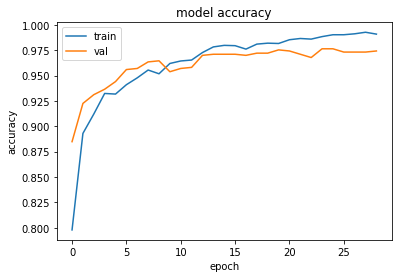

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [78]:
source = "/content/accuracy.png"
destination = "/content/drive/MyDrive/5554/binary_specific_leaf_type/accuracy.png"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/binary_specific_leaf_type/accuracy.png'

In [79]:
# storing history value
with open('HistoryDict.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [80]:
source = "/content/HistoryDict.pickle"
destination = "/content/drive/MyDrive/5554/binary_specific_leaf_type/HistoryDict.pickle"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/binary_specific_leaf_type/HistoryDict.pickle'

## Getting predictions

In [81]:
weights_path = "/content/drive/MyDrive/5554/binary_specific_leaf_type/models/cnn_epochs:24_acc:0.9763.h5"
pred_model = load_model(weights_path)

In [82]:
pred_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 4)       112       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 4)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 8)       296       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        1168

In [83]:
train_generator.class_indices

{'diseased': 0, 'healthy': 1}

In [105]:
def random_prediction(eligible_type, leaf_type):
  path = "/content/curated_dataset/" + eligible_type + "/" + leaf_type + "/"
  img_name = random.choice(os.listdir(path))
  img_path = path + img_name
  img = cv2.imread(img_path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.title(img_name)
  plt.imshow(rgb_img)
  plt.show()

  img_array = rgb_img / 255
  img_array = img_array.reshape(1, 256, 256, 3)
  #print(img_array.shape)
  #print(img_array)
  if pred_model.predict(img_array)[0][0] >= 0.5:
    prediction = "healthy"
  else:
    prediction = "diseased"
  print("Prediction : {}".format(prediction))

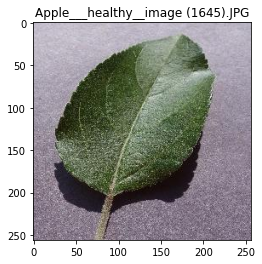

1/1 [==============================] - 0s 21ms/step
Prediction : healthy


In [106]:
random_prediction(eligible_type="Apple", leaf_type="healthy")

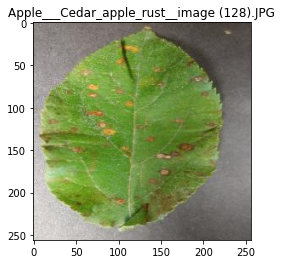

1/1 [==============================] - 0s 15ms/step
Prediction : diseased


In [107]:
random_prediction(eligible_type="Apple",leaf_type="diseased")